# Hypothesis Testing Workshop

## 11 November 2022

### Hosted by and maintained by [SAAS](https://saas.berkeley.edu).
Created by Suparna Kompali, Carlos Gonzalez

**Recommended Reading**: 

* [Testing Hypotheses](https://www.inferentialthinking.com/chapters/11/Testing_Hypotheses.html)

In [34]:
# Run this cell to set up the notebook

# These lines import the Numpy and Datascience modules.
import numpy as np
import pandas as pd
# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

## 1. Setup

A/B testing is a form of hypothesis testing that allows you to make comparisons between two distributions. We may also refer to an A/B test as a permutation test. See the resources above for a more formal introduction to A/B tests.

You'll almost never be explicitly asked to perform an A/B test. Make sure you can identify situations where the test is appropriate and know how to correctly implement each step. Oftentimes, we use an A/B test to determine whether or not two samples came from the same underlying distribution.

Before we can perform an A/B test and moving forward, we'll need to do some setting up with our dataframe.

**Question 1:** Now, let's go ahead and read in the ```ab_data.csv``` data. Store it in ```ab```.

In [17]:
ab = pd.read_csv("ab_data.csv")
ab.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**Question 2:** What is the granularity of this dataframe?

Use the cell below to observe the shape of the dataframe.

In [30]:
ab.shape

(294478, 5)

The line below will show us the number of unique rows

In [31]:
ab.duplicated().sum()

0

In [32]:
ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**Question 3:** In the cell below, assign ```count``` to a table with the sum of the control and treatment group, respectively. 

As a hint, you may use the *to_frame()* function to convert a series object to a Pandas DataFrame.

In [33]:
count = ab["group"].value_counts().to_frame()
count

,group
treatment,147276
control,147202


**Question 4:** In the cell below, assign ```ab_proportions``` to a table with the proportion of converted and non-converted inputs, respectively.

In [23]:
ab_proportions = ab["converted"].value_counts(normalize= True).to_frame()
ab_proportions

,converted
0,0.880341
1,0.119659


Let's observe the number of instances *new_page* occurs:

In [28]:
ab.loc[ab["landing_page"]=='new_page']

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1
...,...,...,...,...,...
294462,677163,2017-01-03 19:41:51.902148,treatment,new_page,0
294465,925675,2017-01-07 20:38:26.346410,treatment,new_page,0
294468,643562,2017-01-02 19:20:05.460595,treatment,new_page,0
294472,822004,2017-01-04 03:36:46.071379,treatment,new_page,0


Let's also observe the number of unique inputs given the ```group``` and ```landing_page``` columns:

In [29]:
ab_landing_page = ab.groupby(["landing_page","group"],as_index= False).size()
ab_landing_page

,landing_page,group,size
0,new_page,control,1928
1,new_page,treatment,145311
2,old_page,control,145274
3,old_page,treatment,1965


As a final note, we will now create a subframe which will concatenate rows 1 and 2 in ```ab_landing_page```. We will be using this new dataframe, ```ab2``` in our A/B Testing.

In [38]:
#Just run this cell

ab2= pd.concat([ab.loc[(ab["landing_page"]== "old_page") &(ab["group"]=="control")], ab.loc[(ab["landing_page"]== "new_page") &(ab["group"]=="treatment")]] , axis=0)
ab2

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
...,...,...,...,...,...
294462,677163,2017-01-03 19:41:51.902148,treatment,new_page,0
294465,925675,2017-01-07 20:38:26.346410,treatment,new_page,0
294468,643562,2017-01-02 19:20:05.460595,treatment,new_page,0
294472,822004,2017-01-04 03:36:46.071379,treatment,new_page,0


Note: You don't have to worry about how we derive the DataFrame above. Make sure you use ```ab2``` instead of ```ab``` in the following exercises.

## 2. A/B Testing

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time? How long do you run to render a decision that neither page is better than another?

These questions are the difficult parts associated with A/B tests in general.

**Question 5:** For now, consider you need to make the decision just based on all the data provided. If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be? You can state your hypothesis in terms of words or in terms of $p_{old}, p_{new}$ which are the converted rates for the old and new pages.

_Null Hypothesis $H_0$:_ $p_{old} \geq p_{new}$, and any observed differences are coincidental and due to chance.

_Alternative Hypothesis $H_1$:_ $p_{new} < p_{old}$ and the observed differences from the null hypothesis are not due to chance but rather significant change.

**Question 6:** Assume under the null hypothesis,  $p_{old}$ and $p_{new}$  both have "true" success rates equal to the converted success rate regardless of page - that is,  $p_{old}$ and $p_{new}$  are equal. Furthermore, assume they are equal to the converted rate in ab_data.csv regardless of the page.

This is going to be setup for our A/B samples, so don't worry too much about how we derive the following:

Under the null and given from qutesion 6, we will assume $p_{old} = p_{new}$. Calculate $p_{new}$, the _average_ conversion rate under the null. Your answer should be around 11%.

In [51]:
conversion = ab2["converted"].mean()
conversion

0.11959667567149027

We are now going to simulate the number of individuals in the treatment group with a conversion rate of ```conversion``` under the null.

In [52]:
#Just run this cell
num_treatment = len(ab2[ab2["group"]== "treatment"])

new_page_converted =np.random.binomial(1, conversion, num_treatment) 
new_page_converted.mean()

0.11814659592185038

We will do the same this as above. We are now going to simulate the number of individuals in the control group with a conversion rate of conversion under the null.

In [53]:
#Just run this cell
num_control = len(ab2[ab2["group"]== "control"])

old_page_converted =np.random.binomial(1, conversion, num_control) 
old_page_converted.mean()

0.11920233489819237

The code above is setting up to calculate a potential test statistic. In the Markdown cell below, write down a test statistic you believe will suffice in proving or disproving the null hypothesis.

As a hint, think about what we can do with the mean values.

Test Statistic: $p_{new} - p_{old}$. If we observe negative values then this is in support of the Null Hypothesis.

**Question 7:** Now, run 10,000 simulations using the test statistic above. Store all 10,000 values in a NumPy array called p_diffs. This cell will take a minute to fully load.

In [54]:
p_diff = []
for i in range (10000):
    new_page_converted =np.random.binomial(1, conversion, num_treatment) 
    old_page_converted =np.random.binomial(1, conversion, num_control) 
    p_diff.append(new_page_converted.mean() - old_page_converted.mean())

**Question 8:** Plot a histogram of the ```p_diffs```. Does this plot look like what you expected?


(array([1.000e+00, 3.600e+01, 2.350e+02, 1.112e+03, 2.612e+03, 3.125e+03,
        2.077e+03, 6.810e+02, 1.130e+02, 8.000e+00]),
 array([-0.00524051, -0.00425632, -0.00327214, -0.00228796, -0.00130377,
        -0.00031959,  0.00066459,  0.00164878,  0.00263296,  0.00361715,
         0.00460133]),
 <BarContainer object of 10 artists>)

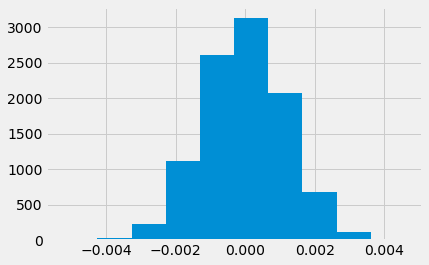

In [50]:
p_diff= np.array(p_diff)

plt.hist(p_diff)

**Question 9:** Assign ```diff_mean``` to the result of taking the mean differences of the treatment and control groups that were marked converted  in the ```ab2``` dataframe.

In [70]:
ab2_converted_treatment = ab2.converted.loc[( ab2["group"] == "treatment")]
ab2_converted_control = ab2.converted.loc[( ab2["group"] == "control")]
diff_mean = ab2_converted_treatment.mean() - ab2_converted_control.mean()
diff_mean

-0.0015790565976871451

Once question 9 is filled out, run the cell below.

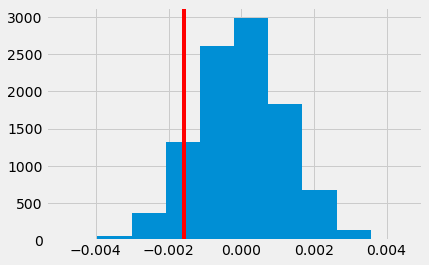

In [59]:
plt.hist(p_diff)
plt.axvline(diff_mean, color='r', label="observed difference")

Let us now calculate the proportion of ```p_diff``` values which are greater than the actual observed differences in the given dataset.

In [75]:
p_diff_Series = pd.Series(p_diff)
(p_diff_Series >  diff_mean).mean()

0.9033

We discussed during the workshop about the p-value and it's significance in A/B Testing. In your own words, explain what your value means in this test. What does this value mean in terms of whether or not there is a difference between the new and old pages?

90 % is very high proportion, this proportion is greater than the actual difference observed in data so we can not reject the null hypothesis. We can not prove the now page have high rate converted, so we keep old page.



Congratulations! You've completed this Notebook.